### 我们结合Gym中21点游戏的环境，深入了解Gym的使用方法。

In [1]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21

def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
            #if is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, self.player, self.dealer

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        while sum_hand(self.player) < 12:
            self.player.append(draw_card(self.np_random))
        while sum_hand(self.dealer) < 12:
            self.dealer.append(draw_card(self.np_random))
        return self._get_obs()

### 利用Gym中内置的21点游戏环境，实现上一个例子。

In [2]:
def policy(observation):
    player_point, dealer_show, player_usable_a = observation
    return 0 if player_point >= 20 else 1

env = BlackjackEnv()

Vs = {}
def episode(env):
    epi = []
    state = env.reset()
    while(True):
        action = policy(state)
        next_state, reward, done, player, dealer = env.step(action)
        epi = epi + [(state, action, reward)]
        if done:
            break
        state = next_state

    return epi

In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function(V, N):
    x_range = np.arange(12, 22)
    y_range = np.arange(1, 11)
    X, Y = np.meshgrid(x_range, y_range) # X, Y为坐标矩阵

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=plt.get_cmap('rainbow'),vmin=-1.0, vmax=1.0)
        
        ax.set_xlabel('Player Point', fontsize=20)
        ax.set_ylabel('Dealer Show', fontsize=20)
        ax.set_zlabel('State Value', fontsize=20)
        ax.set_title(title, fontsize=20)    
        ax.tick_params(labelsize=14)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.savefig(f"{title}.jpg", dpi=600)
        plt.show()

    plot_surface(X, Y, Z_noace, f"No Usable Ace After {N} episodes")
    plot_surface(X, Y, Z_ace, f"Usable Ace After {N} episodes")

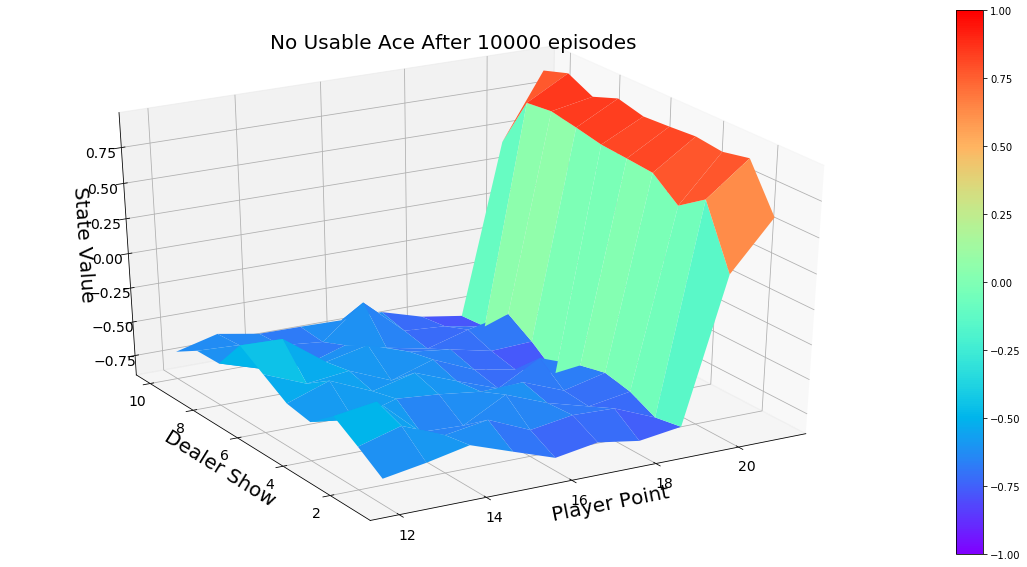

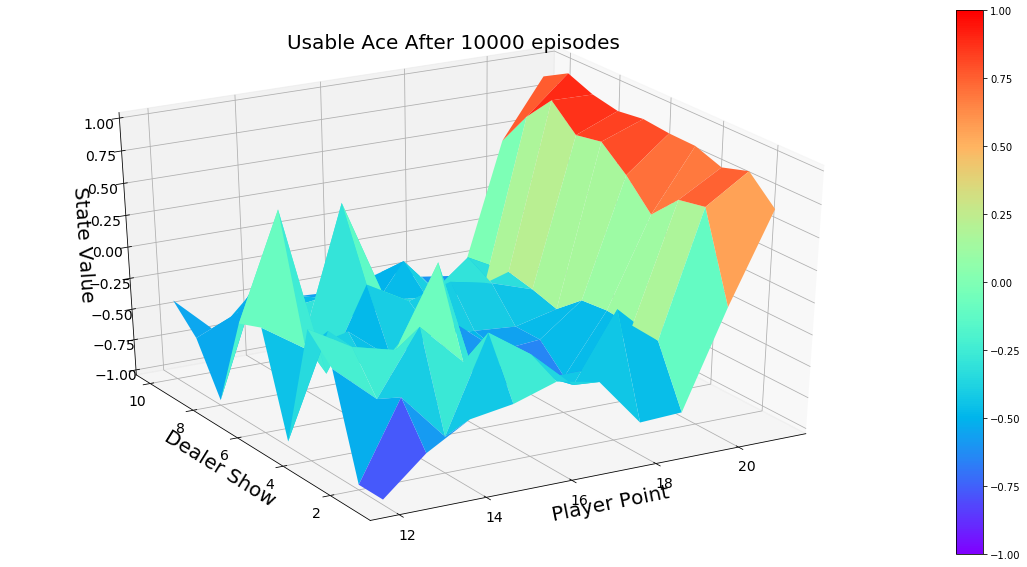

In [4]:
if __name__ == "__main__":
    n = 10000
    discount = 1
    for i in range(n):
        epi = episode(env)
        global Vs
        for idx, item in enumerate(epi): # 每个episode中，各状态只会出现一次
            G = sum([x[2] * (discount ** i) for i, x in enumerate(epi[idx:])])
            Vs.setdefault(item[0],[]).append(G)
    for key in Vs.keys():
        Vs[key] = sum(Vs[key])/len(Vs[key])

    plot_value_function(Vs, n)